In [1]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

The system of ODEs,

$$\frac{dy}{dx} = u$$
$$\frac{du}{dx} + \pi^2 \sin(\pi x) = 0$$

The initial conditions are,

$$y(-1) = 0$$
$$u(-1) = -\pi$$

The exact solutions are,

$$y(x) = \sin(\pi x)$$
$$u(x) = \pi \cos(\pi x)$$

In [2]:
def exact_sol_y(x):
    return torch.sin(np.pi*x)

def exact_sol_u(x):
    return np.pi*torch.cos(np.pi*x)

In [3]:
class PinnModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(in_features=1, out_features=100)
        self.tanh = nn.Tanh()
        self.layer2 = nn.Linear(in_features=100, out_features=2)

    def forward(self, x):
        out = self.layer1(x)
        out = self.tanh(out)
        out = self.layer2(out)
        return out

In [4]:
torch.manual_seed(42)
pinn = PinnModel()
x_test = torch.linspace(-1, 1, 300).view(-1, 1)
y_exact = exact_sol_y(x_test)
u_exact = exact_sol_u(x_test)

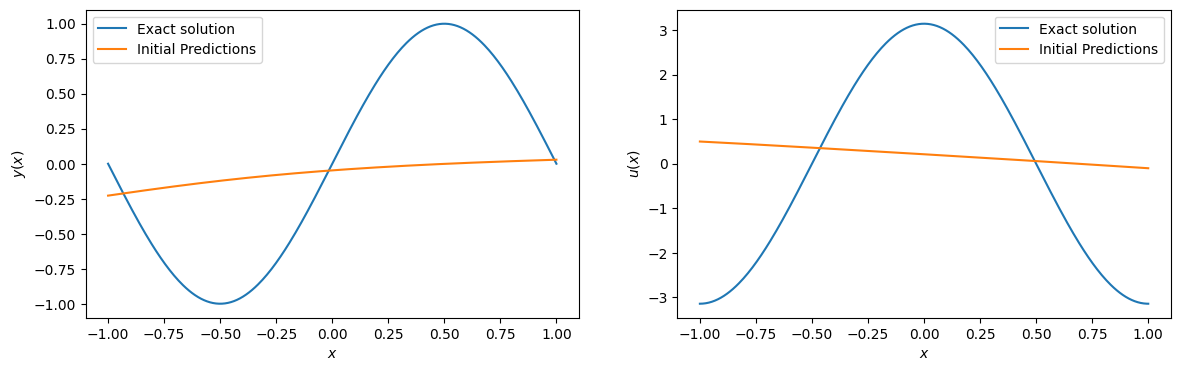

In [5]:
y_preds_initial = pinn(x_test)[:, 1]
u_preds_initial = pinn(x_test)[:, 0]
plt.figure(figsize=(14, 4))
plt.subplot(121)
plt.plot(x_test.squeeze(), y_exact.detach()[:,0], label="Exact solution")
plt.plot(x_test.squeeze(), y_preds_initial.detach(), label="Initial Predictions")
plt.xlabel("$x$")
plt.ylabel("$y(x)$")
plt.legend()

plt.subplot(122)
plt.plot(x_test.squeeze(), u_exact.detach()[:,0], label="Exact solution")
plt.plot(x_test.squeeze(), u_preds_initial.detach(), label="Initial Predictions")
plt.xlabel("$x$")
plt.ylabel("$u(x)$")
plt.legend()
plt.show()

Training step: 0
Loss = 55.892333984375 | Physics_loss = 47.15436935424805 | Initial_loss = 8.737963676452637


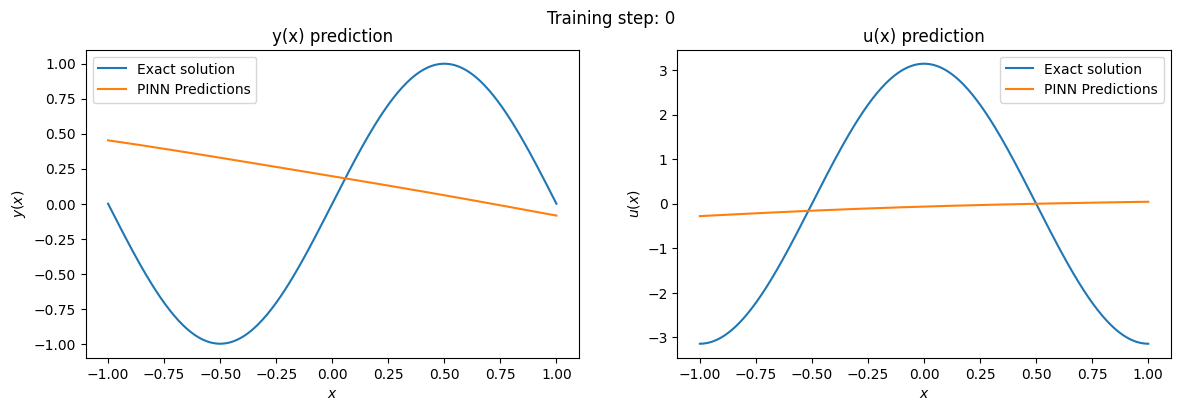

Training step: 1000
Loss = 1.2393784523010254 | Physics_loss = 1.238548755645752 | Initial_loss = 0.000829688273370266


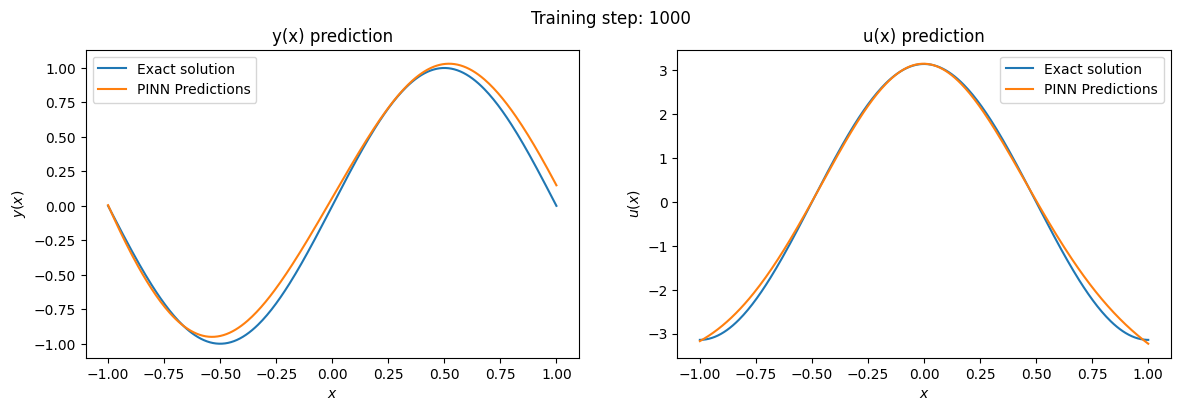

Training step: 2000
Loss = 0.3084069788455963 | Physics_loss = 0.30785074830055237 | Initial_loss = 0.0005562162259593606


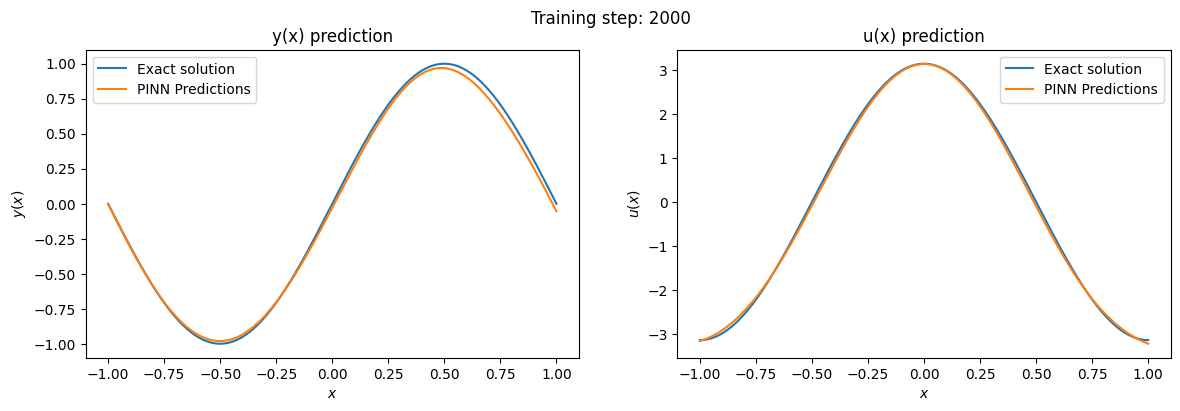

Training step: 3000
Loss = 0.037026453763246536 | Physics_loss = 0.03697847202420235 | Initial_loss = 4.7982037358451635e-05


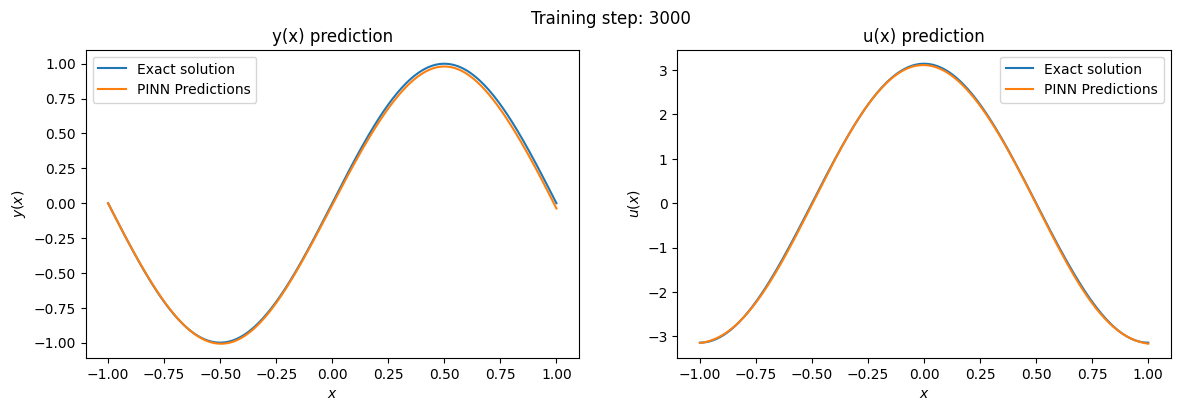

Training step: 4000
Loss = 0.008077213540673256 | Physics_loss = 0.00807324517518282 | Initial_loss = 3.96836867366801e-06


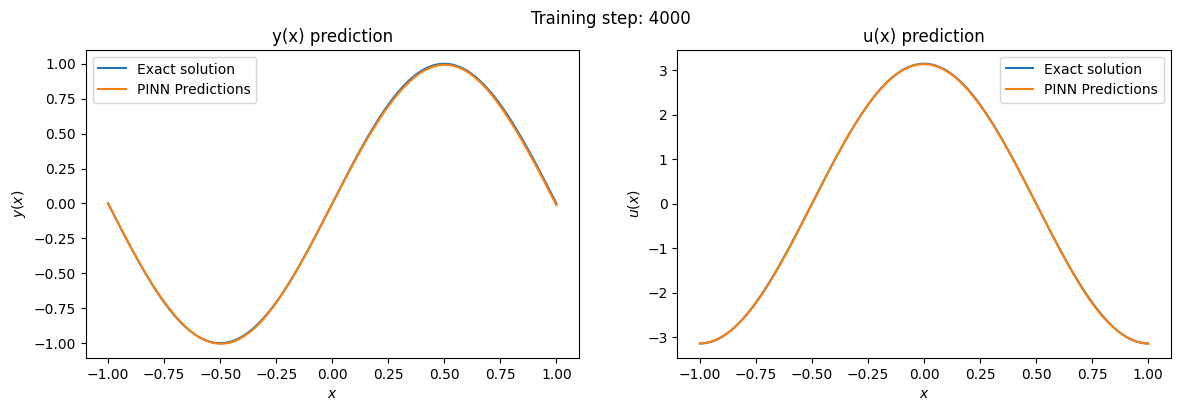

Training step: 5000
Loss = 0.0027534179389476776 | Physics_loss = 0.0027530177030712366 | Initial_loss = 4.001791467089788e-07


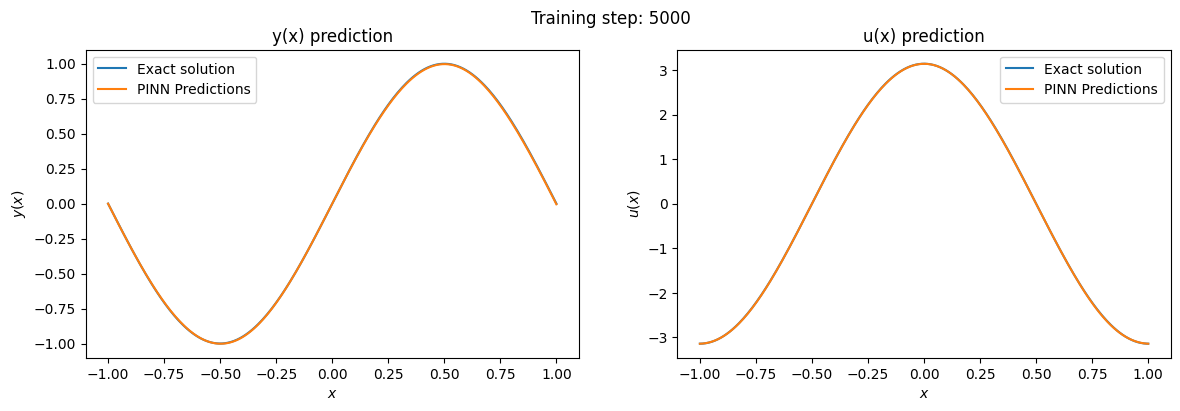

Training step: 6000
Loss = 0.0014781923964619637 | Physics_loss = 0.0014780244091525674 | Initial_loss = 1.6799907598397112e-07


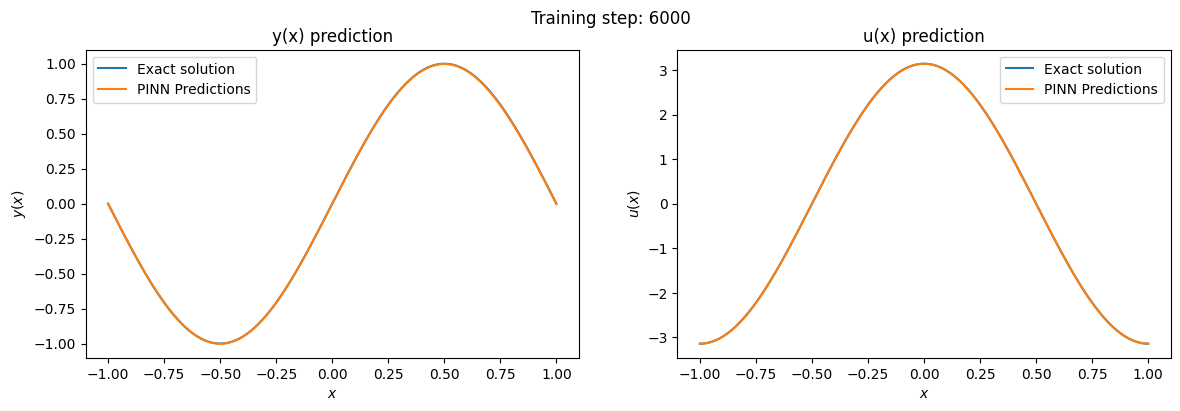

Training step: 7000
Loss = 0.0007636287482455373 | Physics_loss = 0.0007623728597536683 | Initial_loss = 1.2558664366224548e-06


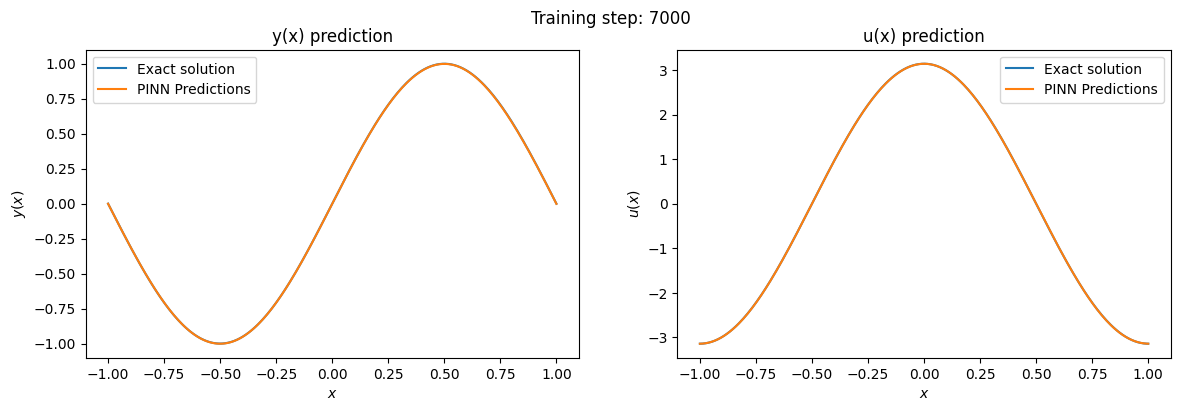

Training step: 8000
Loss = 0.0003868800413329154 | Physics_loss = 0.00038686968036927283 | Initial_loss = 1.0366271396833326e-08


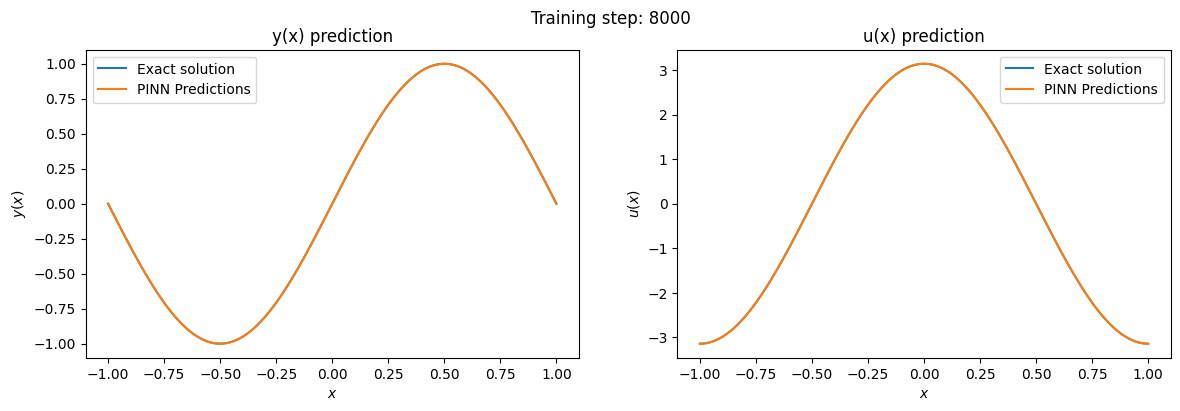

Training step: 9000
Loss = 0.00023826700635254383 | Physics_loss = 0.00023790757404640317 | Initial_loss = 3.5943241982749896e-07


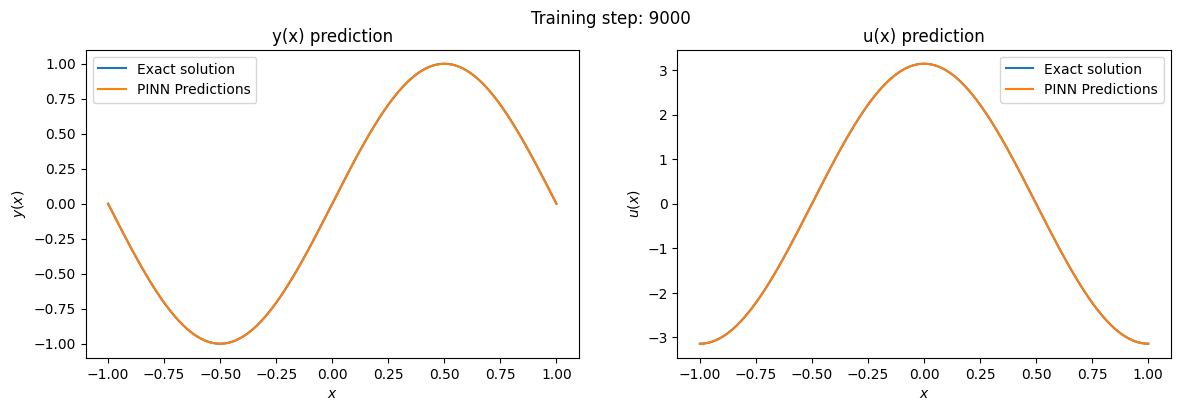

Training step: 10000
Loss = 0.0001846527447924018 | Physics_loss = 0.00018263740639667958 | Initial_loss = 2.0153327113803243e-06


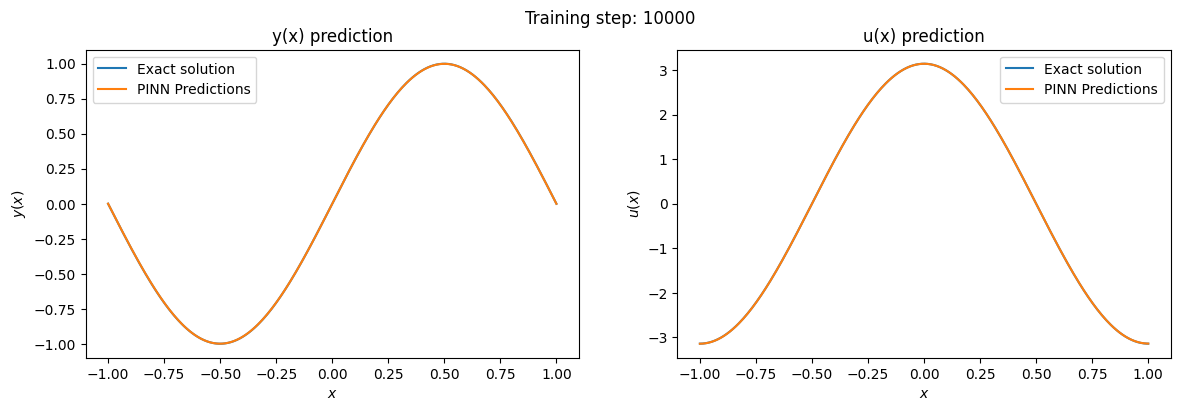

In [6]:
torch.manual_seed(42)
pinn = PinnModel()

x_initial = torch.tensor(-1.0, requires_grad=True).view(-1, 1)

x_physics = torch.linspace(-1, 1, 50, requires_grad=True).view(-1, 1)

optimiser = torch.optim.Adam(pinn.parameters(), lr=0.001)
epochs = 10001

for i in range(epochs):
    optimiser.zero_grad()

    # Initial loss
    y1, u1 = pinn(x_initial)[0]
    loss1 = (torch.squeeze(u1) + np.pi)**2
    loss2 = (torch.squeeze(y1) - 0)**2

    # Physics loss
    sol = pinn(x_physics)
    y = sol[:, 0].view(-1, 1)
    u = sol[:, 1].view(-1, 1)
    dy_dx = torch.autograd.grad(y, x_physics, torch.ones_like(y), create_graph=True)[0]
    du_dx = torch.autograd.grad(u, x_physics, torch.ones_like(u), create_graph=True)[0]
    loss3 = torch.mean((du_dx + (np.pi**2)*torch.sin(np.pi*x_physics))**2)
    loss4 = torch.mean((dy_dx - u)**2)

    # Total loss
    loss = loss1 + loss2 + loss3 + loss4
    loss.backward()
    optimiser.step()

    if i % 1000 == 0:
        print(f"Training step: {i}")
        print(f"Loss = {loss} | Physics_loss = {loss3 + loss4} | Initial_loss = {loss1 + loss2}")
        y_preds, u_preds = [pinn(x_test)[:,i] for i in range(2)]

        plt.figure(figsize=(14, 4))
        plt.suptitle(f"Training step: {i}")

        plt.subplot(121)
        plt.plot(x_test.squeeze(), y_exact.detach()[:,0], label="Exact solution")
        plt.plot(x_test.squeeze(), y_preds.detach(), label="PINN Predictions")
        plt.title("y(x) prediction")
        plt.xlabel("$x$")
        plt.ylabel("$y(x)$")
        plt.legend()

        plt.subplot(122)
        plt.plot(x_test.squeeze(), u_exact.detach()[:,0], label="Exact solution")
        plt.plot(x_test.squeeze(), u_preds.detach(), label="PINN Predictions")
        plt.title("u(x) prediction")
        plt.xlabel("$x$")
        plt.ylabel("$u(x)$")
        plt.legend()
        plt.show()

# Inverse PINN

Given the system of ODEs,

$$\frac{dy}{dx} = ku$$
$$\frac{du}{dx} + p^2 \sin(px) = 0$$

Our goal is to estimate the values of $k$ and $p$ given the observational data points.

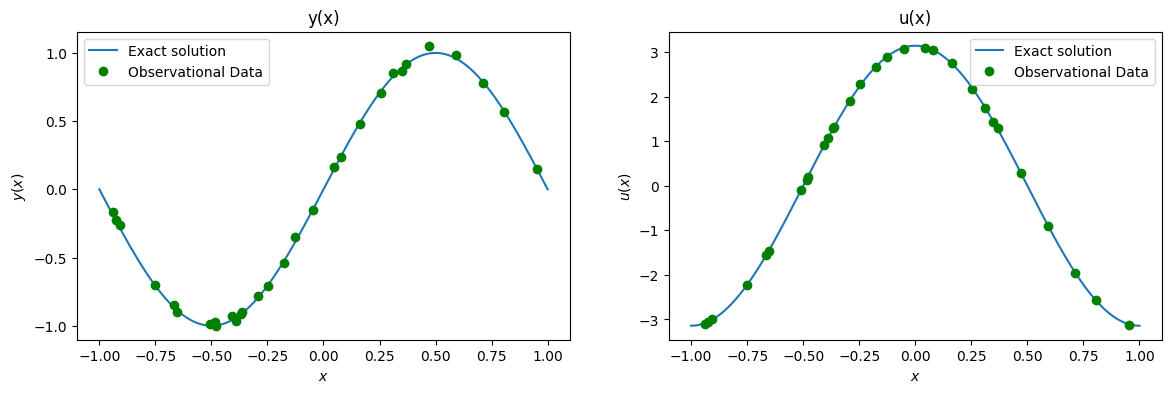

In [7]:
x_obs = 2 * torch.rand(30, 1) - 1
y_obs = exact_sol_y(x_obs) + 0.02 * torch.randn_like(x_obs)
u_obs = exact_sol_u(x_obs) + 0.02 * torch.randn_like(x_obs)
plt.figure(figsize=(14,4))
plt.subplot(121)
plt.plot(x_test.squeeze(), y_exact.detach()[:,0], label="Exact solution")
plt.plot(x_obs.squeeze(), y_obs.detach()[:,0], 'og', label="Observational Data")
plt.xlabel("$x$")
plt.ylabel("$y(x)$")
plt.title("y(x)")
plt.legend()

plt.subplot(122)
plt.plot(x_test.squeeze(), u_exact.detach()[:,0], label="Exact solution")
plt.plot(x_obs.squeeze(), u_obs.detach()[:,0], 'og', label="Observational Data")
plt.xlabel("$x$")
plt.ylabel("$u(x)$")
plt.title("u(x)")
plt.legend()
plt.show()

Training step: 0
Loss = 5.435157299041748 | Physics_loss = 0.09092404693365097 | Data_loss = 5.34423303604126


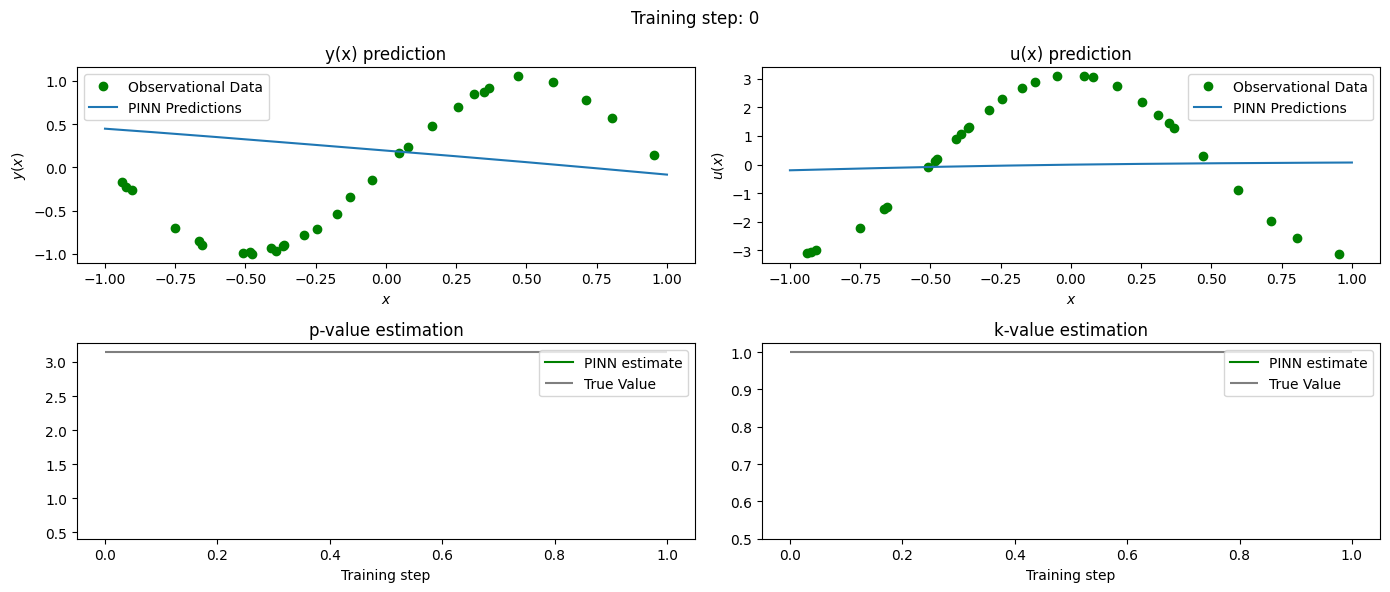

Training step: 1000
Loss = 1.67084801197052 | Physics_loss = 0.16249577701091766 | Data_loss = 1.508352279663086


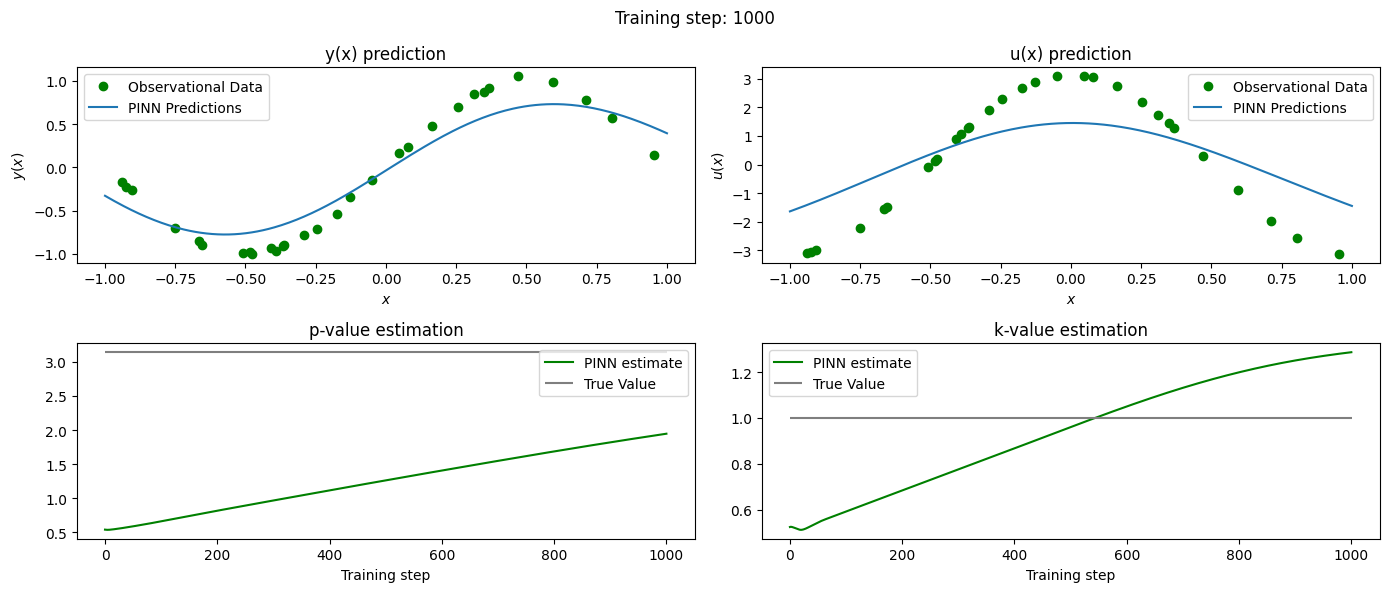

Training step: 2000
Loss = 0.17086172103881836 | Physics_loss = 0.02152947336435318 | Data_loss = 0.14933224022388458


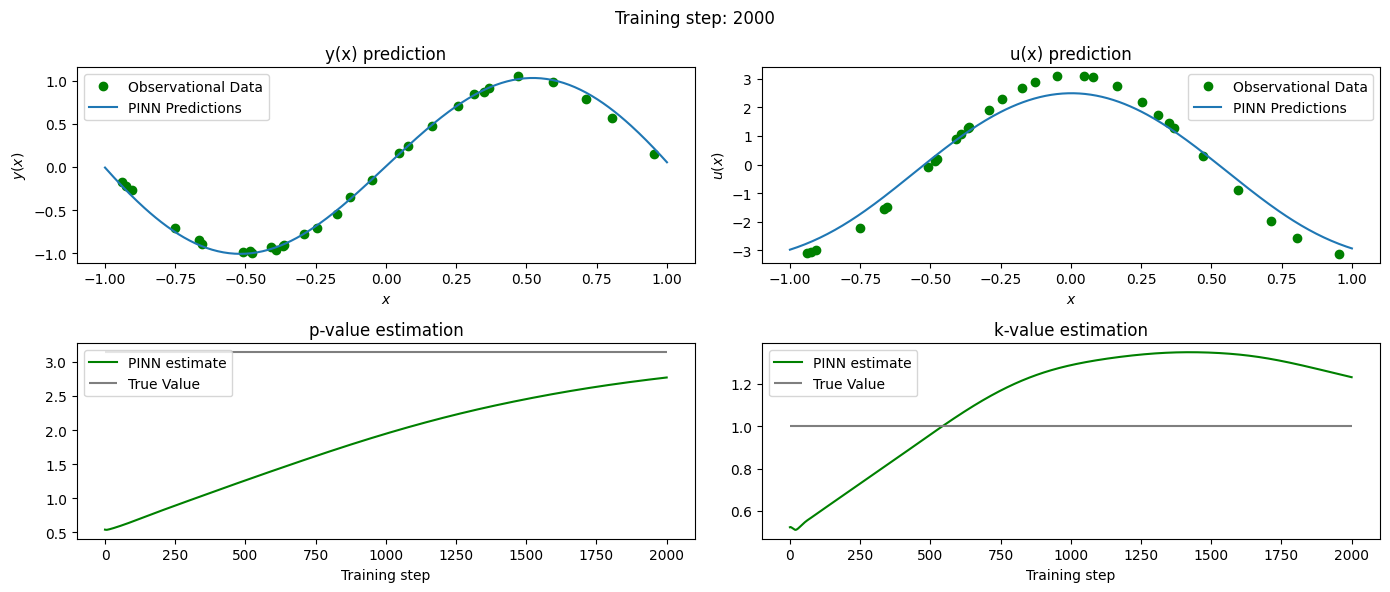

Training step: 3000
Loss = 0.00972622912377119 | Physics_loss = 0.002842765301465988 | Data_loss = 0.0068834638223052025


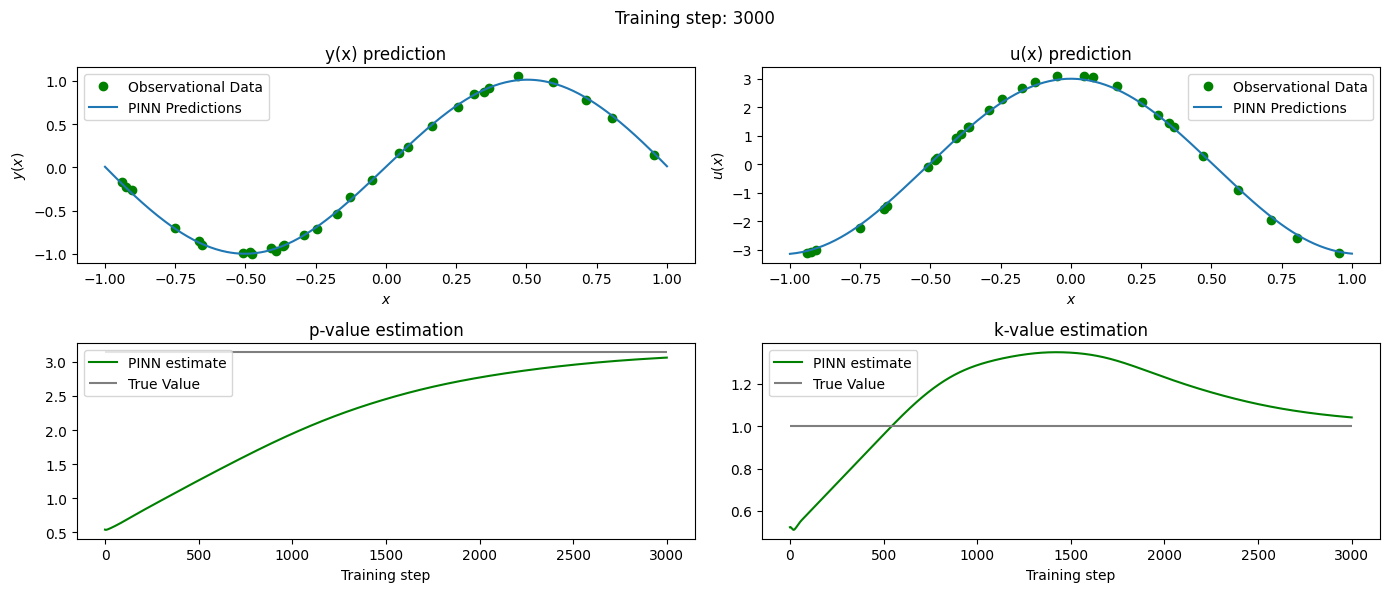

Training step: 4000
Loss = 0.001669623889029026 | Physics_loss = 0.0010019440669566393 | Data_loss = 0.0006676798220723867


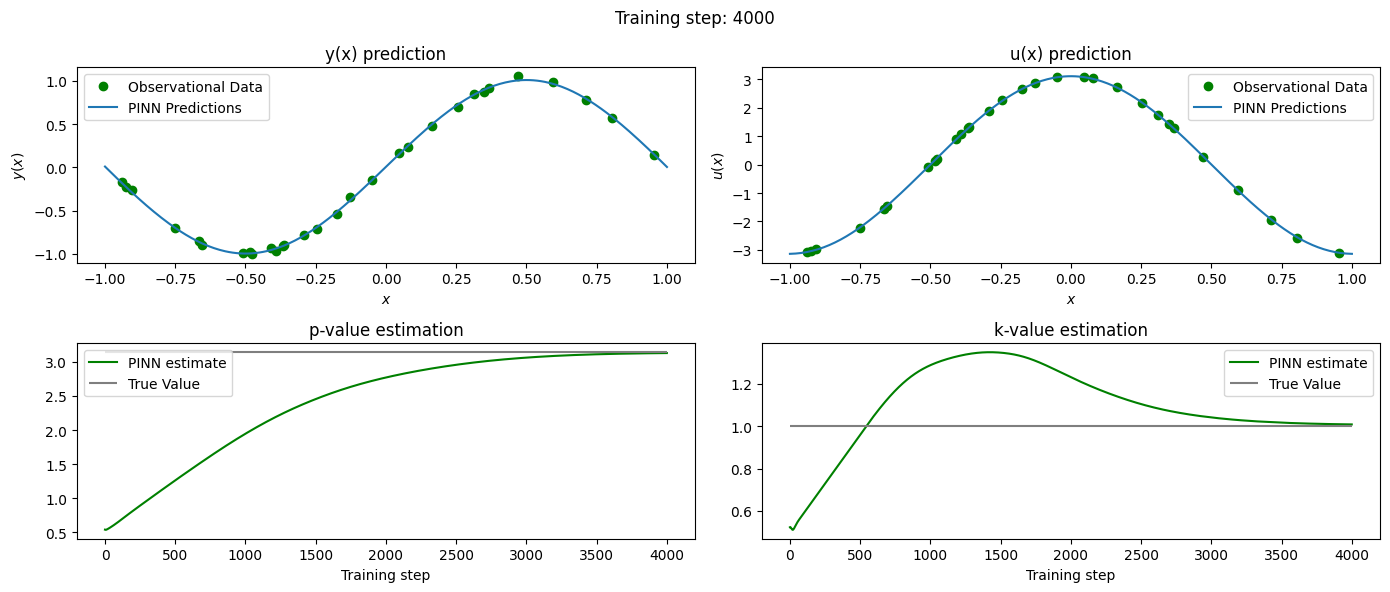

Training step: 5000
Loss = 0.0010227556340396404 | Physics_loss = 0.0004600715183187276 | Data_loss = 0.0005626842030324042


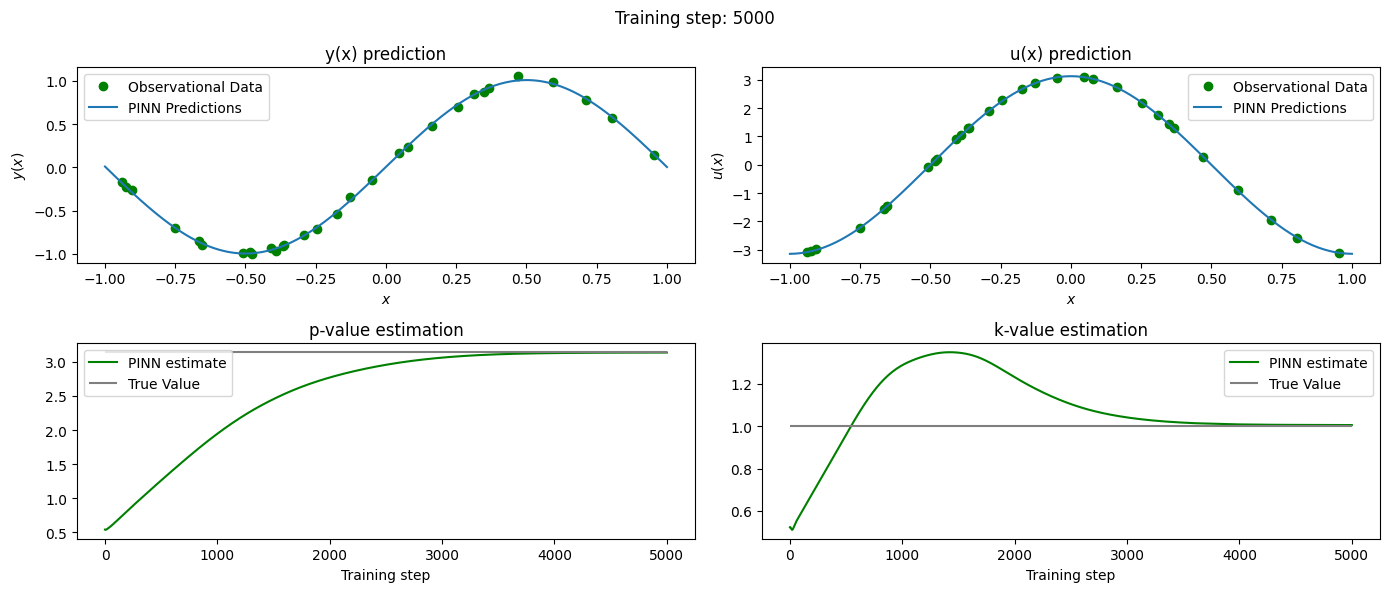

Training step: 6000
Loss = 0.0008168069762177765 | Physics_loss = 0.0002577091509010643 | Data_loss = 0.0005590977962128818


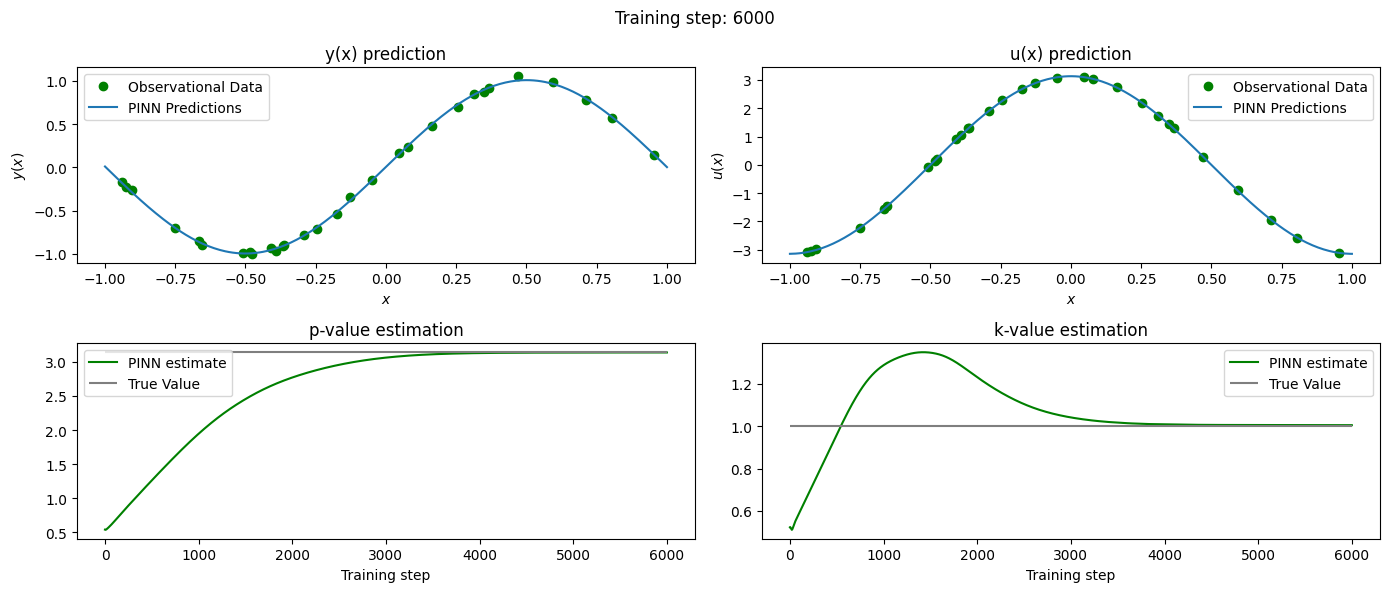

Training step: 7000
Loss = 0.0007273060036823153 | Physics_loss = 0.0001682135189184919 | Data_loss = 0.0005590924993157387


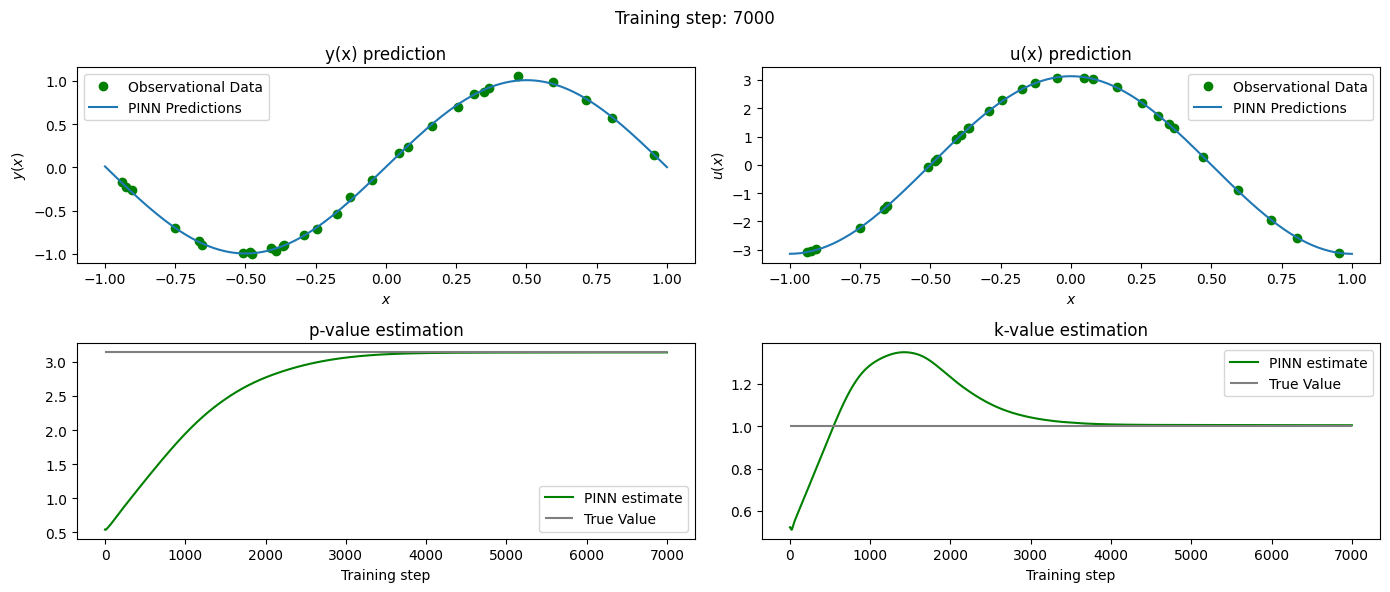

Training step: 8000
Loss = 0.0006800899282097816 | Physics_loss = 0.00012341617548372597 | Data_loss = 0.0005566737381741405


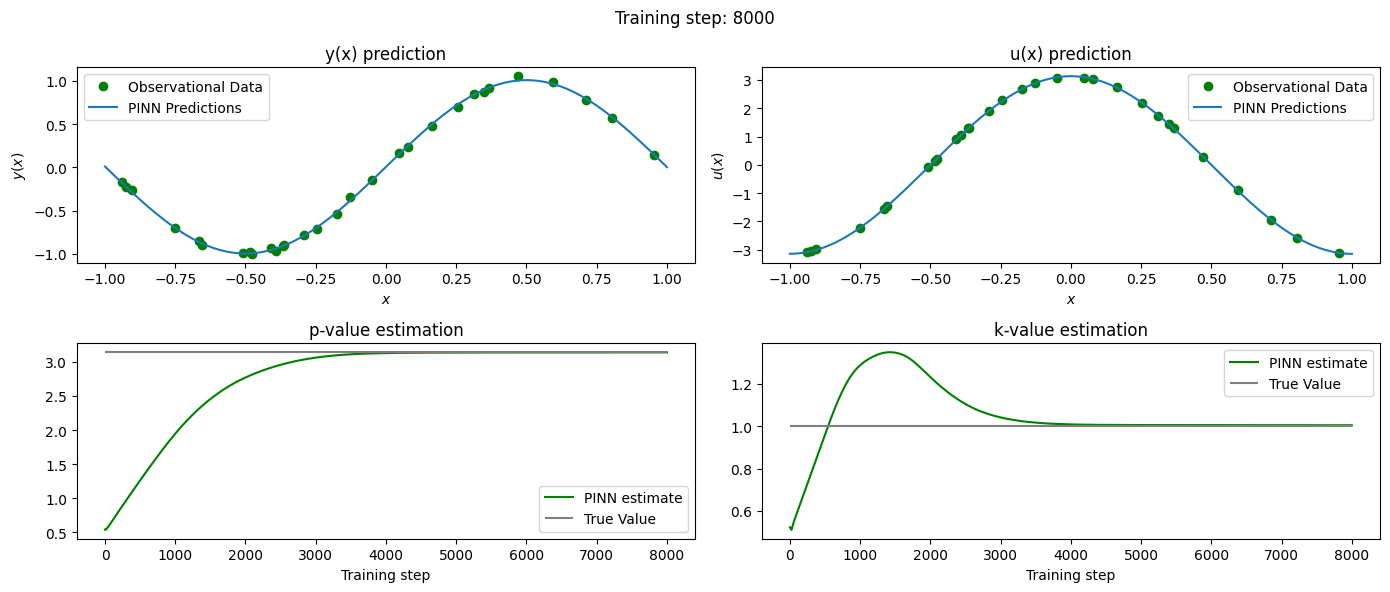

Training step: 9000
Loss = 0.0006535006104968488 | Physics_loss = 9.831319039221853e-05 | Data_loss = 0.0005551874055527151


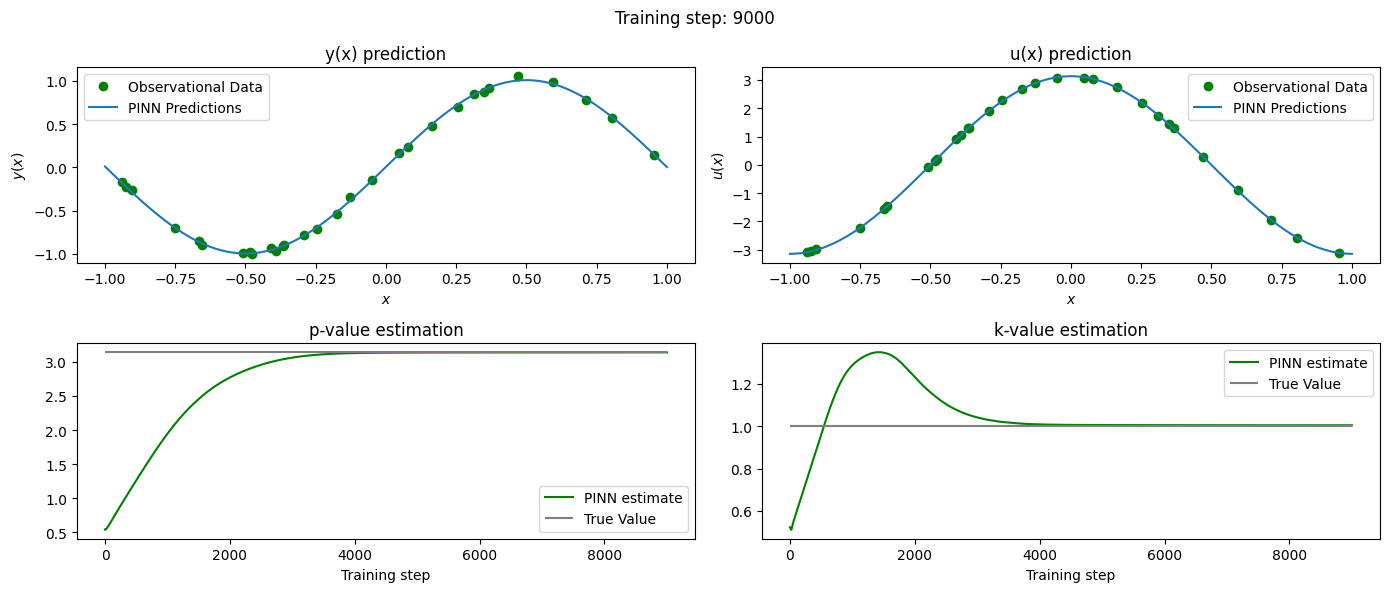

Training step: 10000
Loss = 0.000637996185105294 | Physics_loss = 8.282465569209307e-05 | Data_loss = 0.0005551715148612857


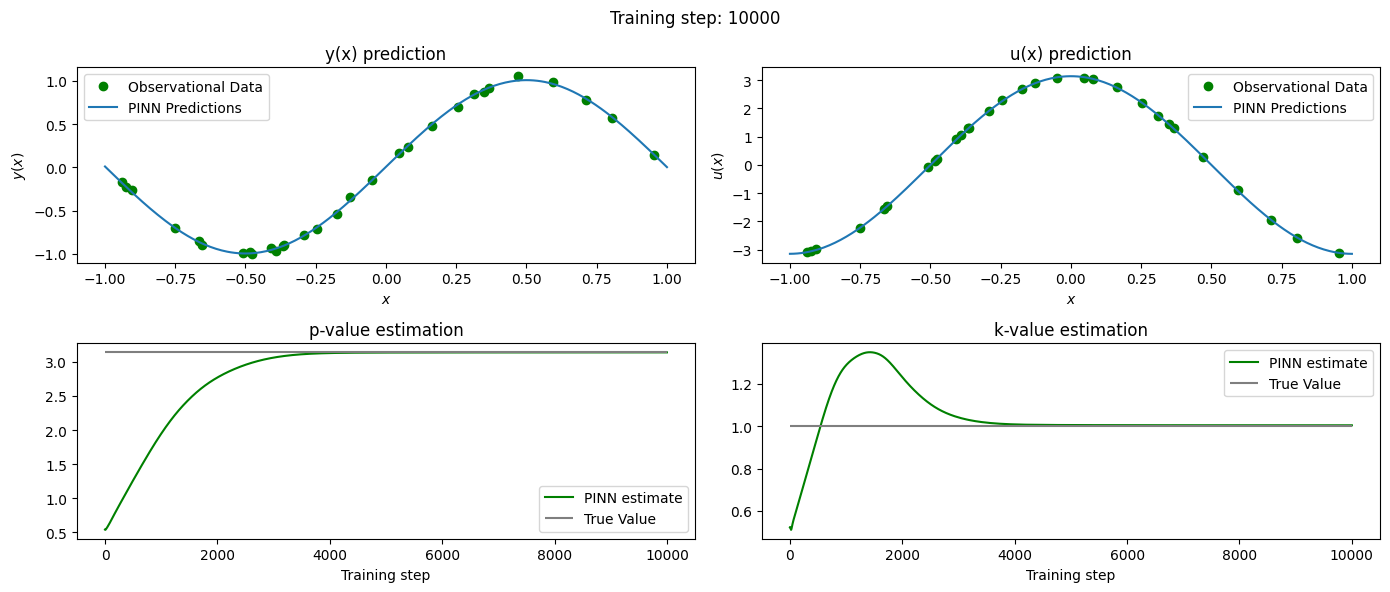

In [8]:
torch.manual_seed(42)
pinn = PinnModel()

x_physics = torch.linspace(-1, 1, 50, requires_grad=True).view(-1, 1)

p = torch.nn.Parameter(torch.rand(1, requires_grad=True))
k = torch.nn.Parameter(torch.rand(1, requires_grad=True))
optimiser = torch.optim.Adam(list(pinn.parameters()) + [p, k], lr=0.001)
epochs = 10001
ps = []
ks = []

for i in range(epochs):
    optimiser.zero_grad()

    # Data loss
    sol = pinn(x_obs)
    y = sol[:, 0].view(-1, 1)
    u = sol[:, 1].view(-1, 1)
    loss1 = torch.mean((y - y_obs)**2)
    loss2 = torch.mean((u - u_obs)**2)

    # Physics loss
    sol = pinn(x_physics)
    y = sol[:, 0].view(-1, 1)
    u = sol[:, 1].view(-1, 1)
    dy_dx = torch.autograd.grad(y, x_physics, torch.ones_like(y), create_graph=True)[0]
    du_dx = torch.autograd.grad(u, x_physics, torch.ones_like(u), create_graph=True)[0]
    loss3 = torch.mean((du_dx + (p**2)*torch.sin(p*x_physics))**2)
    loss4 = torch.mean((dy_dx - k*u)**2)

    # Total loss
    loss = loss1 + loss2 + loss3 + loss4
    loss.backward()
    optimiser.step()

    ps.append(p.item())
    ks.append(k.item())

    if i % 1000 == 0:
        print(f"Training step: {i}")
        print(f"Loss = {loss} | Physics_loss = {loss3 + loss4} | Data_loss = {loss1 + loss2}")
        y_preds, u_preds = [pinn(x_test)[:,i] for i in range(2)]

        plt.figure(figsize=(14, 6))
        plt.suptitle(f"Training step: {i}")

        plt.subplot(221)
        plt.plot(x_obs.squeeze(), y_obs.detach()[:,0], 'og', label="Observational Data")
        plt.plot(x_test.squeeze(), y_preds.detach(), label="PINN Predictions")
        plt.title("y(x) prediction")
        plt.xlabel("$x$")
        plt.ylabel("$y(x)$")
        plt.legend()

        plt.subplot(222)
        plt.plot(x_obs.squeeze(), u_obs.detach()[:,0], 'og', label="Observational Data")
        plt.plot(x_test.squeeze(), u_preds.detach(), label="PINN Predictions")
        plt.title("u(x) prediction")
        plt.xlabel("$x$")
        plt.ylabel("$u(x)$")
        plt.legend()

        plt.subplot(223)
        plt.plot(ps, label="PINN estimate", c='green')
        plt.hlines(np.pi, 0, len(ps), color="tab:grey", label="True Value")
        plt.title("p-value estimation")
        plt.xlabel("Training step")
        plt.legend()

        plt.subplot(224)
        plt.plot(ks, label="PINN estimate", c='green')
        plt.hlines(1, 0, len(ps), color="tab:grey", label="True Value")
        plt.title("k-value estimation")
        plt.xlabel("Training step")
        plt.legend()
        plt.tight_layout()
        plt.show()

# Problem - 2

The system of ODEs,

$$\frac{dx}{dt} = 2x$$
$$\frac{dy}{dt} = 2x+4y$$

The initial conditions are,

$$x(0) = 3$$
$$y(0) = 0$$

The exact solutions are,

$$x(t) = 3e^{2t}$$
$$y(t) = -3e^{2t} + 3e^{4t}$$

In [2]:
class PinnModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.norm = nn.LayerNorm(normalized_shape=1, eps=1e-6)
        self.layer1 = nn.Linear(in_features=1, out_features=100)
        self.tanh = nn.Tanh()
        self.layer2 = nn.Linear(in_features=100, out_features=2)

    def forward(self, x):
        out = self.norm(out)
        out = self.layer1(x)
        out = self.tanh(out)
        out = self.layer2(out)
        return out

In [3]:
def sol_x(t):
    return 3*torch.exp(2*t)

def sol_y(t):
    return -3*torch.exp(2*t) + 3*torch.exp(4*t)

def normalisation(k_Ca):
    min_Ca = torch.min(k_Ca)
    max_Ca = torch.max(k_Ca)
    return (k_Ca - min_Ca) / (max_Ca - min_Ca)

In [5]:
torch.manual_seed(42)
pinn = PinnModel()

t_max = torch.tensor(2.0)
t_test = torch.linspace(0, t_max, 500).view(-1, 1)
t_initial = torch.tensor(0.0, requires_grad=True).view(-1, 1)
t_physics = (torch.linspace(0, t_max, 100).view(-1, 1)).requires_grad_(True)

x_exact = sol_x(t_test)
y_exact = sol_y(t_test)

optimiser = torch.optim.Adam(pinn.parameters(), lr=0.01)
lam1, lam2 = 1e-1, 1e-3
epochs = 10001

for i in range(epochs):

    optimiser.zero_grad()

    # Initial loss
    x_0, y_0 = pinn(t_initial)[0]
    loss1 = (torch.squeeze(x_0) - 1)**2
    loss2 = (torch.squeeze(y_0) - 0)**2

    # Physics loss
    sol = pinn(t_physics)
    x = sol[:, 0].view(-1, 1)
    y = sol[:, 1].view(-1, 1)
    dxdt = torch.autograd.grad(x, t_physics, torch.ones_like(x), create_graph=True)[0]
    dydt = torch.autograd.grad(y, t_physics, torch.ones_like(y), create_graph=True)[0]
    loss3 = torch.mean((dxdt - 2*x)**2)
    loss4 = torch.mean((dydt - (2*x + 4*y))**2)

    # Total loss
    loss =  lam1*(loss1 + loss2) + lam2*(loss3 + loss4)
    loss.backward()
    optimiser.step()

    if i % 1000 == 0:
        print(f"Training step: {i}")
        print(f"Loss = {loss} | Physics_loss = {loss3 + loss4} | Initial_loss = {loss1 + loss2}")
        x_preds, y_preds = [pinn(t_test)[:,i] for i in range(2)]

        plt.figure(figsize=(14, 4))
        plt.suptitle(f"Training step: {i}")

        plt.subplot(121)
        plt.plot(t_test.squeeze(), x_exact.detach()[:,0], label="Exact solution")
        plt.plot(t_test.squeeze(), x_preds.detach(), label="PINN Predictions")
        plt.title("x(t) prediction")
        plt.xlabel("$t$")
        plt.ylabel("$x(t)$")
        plt.legend()

        plt.subplot(122)
        plt.plot(t_test.squeeze(), y_exact.detach()[:,0], label="Exact solution")
        plt.plot(t_test.squeeze(), y_preds.detach(), label="PINN Predictions")
        plt.title("y(t) prediction")
        plt.xlabel("$t$")
        plt.ylabel("$y(t)$")
        plt.legend()
        plt.show()


UnboundLocalError: cannot access local variable 'out' where it is not associated with a value